<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-4--job-resume-improvement/02_matrix_data_dimension_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dimension reduction of matrix data

Dimension reduction is a series of techniques for shrinking data while retaining its
information content. These techniques permeate many of our everyday digital
activities.

These are the following advantages of dimensionally reduced data:
* More compact data is easier to transfer and store.
* Algorithmic tasks require less time when our data is smaller.
* Certain complex tasks, like cluster detection, can be simplified by removing
unnecessary information.

We want to cluster thousands
of text documents by topic. The clustering will entail computing a matrix of all-by-all document similarities.

As we know, this computation can be slow. Dimension reduction can speed up the process by reducing the number
of data matrix columns. 

As a further bonus, dimensionally reduced text data has been
shown to yield higher-quality topic clusters.

##Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from collections import defaultdict
from collections import Counter
import time
import numpy as np
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt

##Clustering 2D data in one dimension

Dimension reduction has many uses, including more interpretable clustering.

Let’s start by simulating customer heights. Our heights range from
60 inches (5 ft) to 78 inches (6.5 ft). We fabricate these heights by calling
np.arange(60, 78, 0.1). 

This returns an array of heights between 60 and 78 inches,
where each consecutive height increases by 0.1 inches.

In [4]:
# Simulating a range of heights
heights = np.arange(60, 78, 0.1)

It has been shown that, on average, a person’s
weight in pounds equals approximately `4 * height - 130`. 

Of course, each individual
person’s weight fluctuates around this average value.

In [5]:
# Simulating weights using heights
np.random.seed(0)

random_fluctuations = np.random.normal(scale=10, size=heights.size)
weights = 4 * heights - 130 + random_fluctuations

Let’s store and plot these measured coordinates.

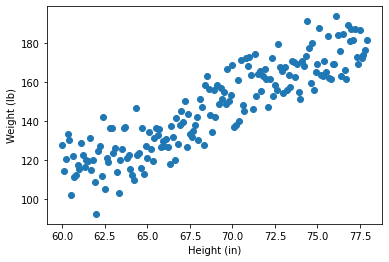

In [6]:
measurements = np.array([heights, weights])

plt.scatter(measurements[0], measurements[1])
plt.xlabel("Height (in)")
plt.ylabel("Weight (lb)")
plt.show()

As a reminder, Matplotlib manipulates its 2D axes to make the final plot aesthetically pleasing. Normally, this is a good thing. 

However, we’ll soon be rotating the plot to simplify our data. The rotation
will shift the axes scaling, making the rotated data difficult to compare with the original data plot. 

Consequently, we should equalize our axes to obtain consistent visual
output.

Let’s equalize the axes and hen regenerate the plot.

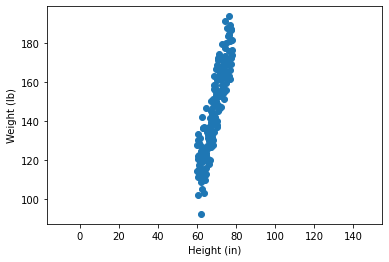

In [7]:
# Plotting 2D measurements using equally scaled axes
plt.scatter(measurements[0], measurements[1])
plt.xlabel("Height (in)")
plt.ylabel("Weight (lb)")
plt.axis("equal")
plt.show()

If we rotate our data toward the x-axis, the horizontal x-values should be sufficient to
distinguish between points. We can thus cluster the data without relying on the vertical y-values. 

Effectively, we’ll be able to delete the y-values with minimal information loss.
That deletion will reduce our data from two dimensions to one.

###Reducing dimensions using rotation

In [ ]:
# Rotating the plot
centered_data = np.array([heights - heights.mean(), weights - weights.mean()])

plt.scatter(centered_data[0], centered_data[1])
# Visualizes the x-axis and y-axis to mark the location of the origin
plt.axhline(0, c="black")
plt.axvline(0, c="black")
plt.xlabel("Centralized Height (in)")
plt.ylabel("Centralized Weight (lb)")
plt.axis("equal")
plt.show()